In [1]:
import numpy as np
import matplotlib.pyplot as plt
from simulator import Simulator
from utils import utils
model = None
online = False
online = True
model = utils.load_model("SpikingAE_new.pth")
seeds = [5, 26, 33, 58, 91, 73, 88, 12, 5, 39, 47, 61, 79, 84, 95, 14, 27, 42, 22, 17]
run = 1
run_path =  "simulation_data_online/"
THR_base = 0.01087567
simulator = Simulator(
    num_run=run,
    # scene_path='C:/Users/User/Desktop/PField/potential_fields_sim.ttt',
    scene_path='C:\\Users\\anton\\Documents\\PhD\\Spiking\\PotentialField_Sim\\potential_fields_sim.ttt',
    seed=seeds,
    num_blocks=20,
    min_distance=2.0,
    min_goal_distance=8.0,
    save_path=run_path,
    online=online,
    model=model,
    THR_base=THR_base
)

pioneer_pos, block_pos, goal_pos, preds, thresholds, speed = simulator.run()

Finita run


In [2]:
pioneer_positions = pioneer_pos[0]
block_positions = block_pos[0]
goal_positions = goal_pos[0]

preds = preds[0]
thr = thresholds[0]
speed = speed[0]

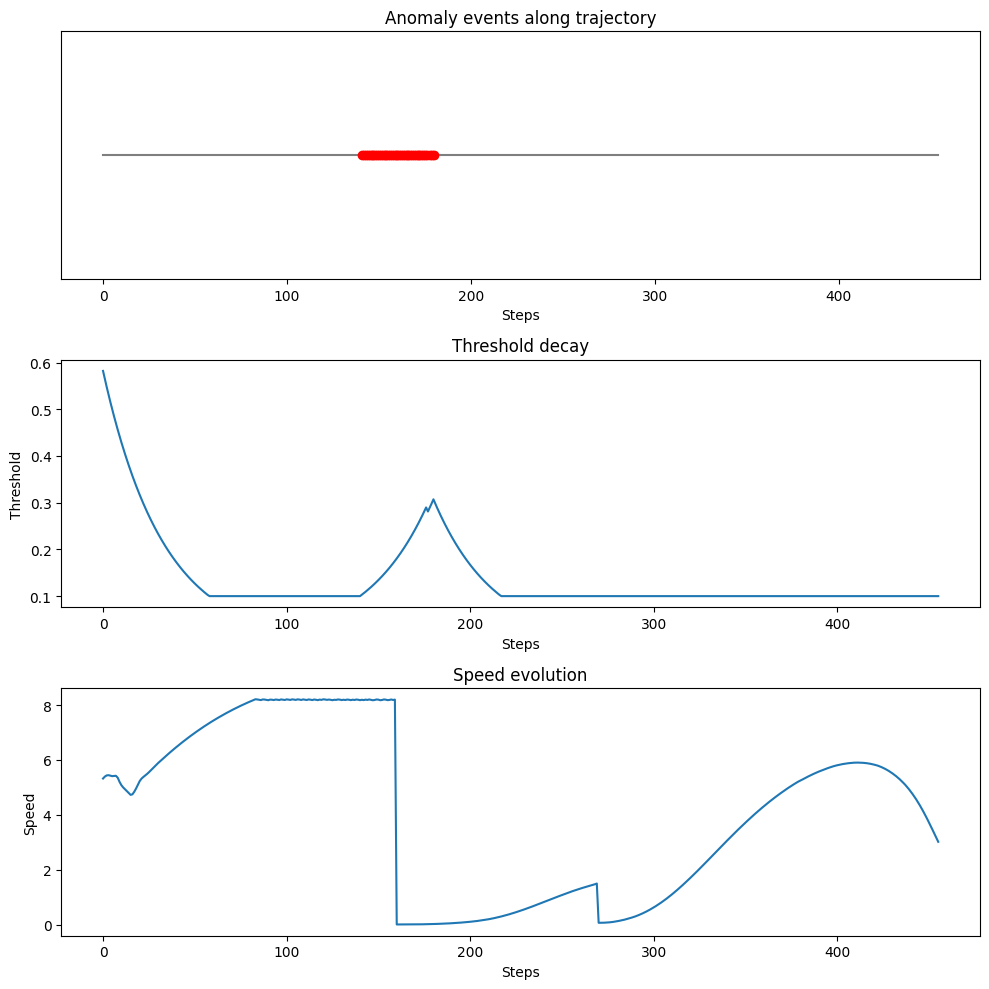

In [ ]:
fig, axes = plt.subplots(
    3, 1,
    figsize=(10, 10),
    gridspec_kw={'height_ratios': [0.3, 0.3, 0.3]}
)

ax = axes[0]

frames = np.arange(len(pioneer_positions)-1)
y_line = np.zeros_like(frames)

ax.plot(frames, y_line, '-', color='black', alpha=0.5)

anom_idx = np.where(preds == 1)[0]

ax.plot(anom_idx, np.zeros_like(anom_idx), 'ro')

ax.set_yticks([])
ax.set_xlabel("Steps")
ax.set_title("Anomaly timeline")


ax.set_title("Anomaly events along trajectory")

ax = axes[1]

if isinstance(thr, float):
    thr = np.full(len(pioneer_positions), thr)
ax.plot(thr)
ax.set_title("Threshold decay")
ax.set_xlabel("Steps")
ax.set_ylabel("Threshold")

ax = axes[2]
ax.plot(speed)
ax.set_title("Speed evolution")
ax.set_xlabel("Steps")
ax.set_ylabel("Speed")

plt.tight_layout()
plt.show()


In [1]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import time
import csv
import os
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
def plot_tot(pioneer_positions, block_positions, goal_position):
    # Plot
        plt.figure(figsize=(10, 10))
        plt.title("Traiettorie Pioneer con goal e blocchi")
        plt.xlabel("X [m]")
        plt.ylabel("Y [m]")
        plt.grid(True)
        plt.axis('equal')
        block_size = 1.0
        plt.xticks(np.arange(8.5, -8.5, -1))
        plt.yticks(np.arange(8.5, -8.5, -1))
        # plt.plot(pioneer_positions[0][0], pioneer_positions[0][1] , 'ro', markersize=12, label='Start')
        plt.plot(pioneer_positions[0], pioneer_positions[1] , 'ro', markersize=12, label='Start')


        # x_path = [pos[0] for pos in pioneer_positions[1:]]
        # y_path = [pos[1] for pos in pioneer_positions[1:]]
        # plt.plot(x_path, y_path, '-', label='Path')
        # Goal
        plt.plot(goal_position[0], goal_position[1] , 'go', markersize=12, label='Goal')

        for i in range(len(block_positions)):
                x, y = block_positions[i]
                rect = plt.Rectangle((x - block_size/2, y - block_size/2), block_size, block_size,
                                linewidth=1, edgecolor='r', facecolor='none')
                plt.gca().add_patch(rect)
                plt.plot(x, y, 'r.', markersize=5)
        plt.grid(False)
        plt.legend()
        plt.show()


In [3]:
def attractive_force(robot_x, robot_y, goal_x, goal_y):
    dx = goal_x - robot_x
    dy = goal_y - robot_y
    fx_attr = KA * dx
    fy_attr = KA * dy
    return fx_attr, fy_attr

def repulsive_force(robot_x, robot_y, obstacle_x, obstacle_y):
    dx = robot_x - obstacle_x
    dy = robot_y - obstacle_y
    dist_to_obstacle = np.sqrt(dx**2 + dy**2)
    dist_to_obstacle -= 0.5
    if dist_to_obstacle < THR:
        fx_rep = KR * (1.0 / dist_to_obstacle - 1.0 / THR) * (1.0 / (dist_to_obstacle ** 2)) * (dx / dist_to_obstacle)
        fy_rep = KR * (1.0 / dist_to_obstacle - 1.0 / THR) * (1.0 / (dist_to_obstacle ** 2)) * (dy / dist_to_obstacle)
    else:
        fx_rep = 0.0
        fy_rep = 0.0
    return fx_rep, fy_rep

def compute_angle(fx, fy, pioneer_orientation):
    angle = np.arctan2(fy, fx)
    current_orientation = pioneer_orientation
    angle_diff = (angle - current_orientation + np.pi) % (2 * np.pi) - np.pi
    if abs(angle_diff) < .1:
        rot_speed_raw = 0.0
    else:
        rot_speed_raw = KP_rot * angle_diff

    return rot_speed_raw, angle_diff

def p_field(pioneer_position, goal_position, block_positions, pioneer_orientation):
    dx = goal_position[0] - pioneer_position[0]
    dy = goal_position[1] - pioneer_position[1]
    distance_to_goal = np.sqrt(dx**2 + dy**2)
    fx_attr, fy_attr = attractive_force(pioneer_position[0], pioneer_position[1], goal_position[0], goal_position[1])
    fx_rep_total = 0.0
    fy_rep_total = 0.0
    for ox, oy in block_positions :
        fx_rep, fy_rep = repulsive_force(pioneer_position[0], pioneer_position[1], ox, oy)
        fx_rep_total += fx_rep
        fy_rep_total += fy_rep
    fx_total = fx_attr + fx_rep_total
    fy_total = fy_attr + fy_rep_total
    rot_speed_raw, angle_diff = compute_angle(fx_total, fy_total, pioneer_orientation)
    rot_speed = rot_speed_raw 

    # Speed avanti
    fwd_speed = KP_fwd * np.exp(-2 * abs(angle_diff))


    L = 0.4
    v_l = fwd_speed - rot_speed * L / 2
    v_r = fwd_speed + rot_speed * L / 2
    return v_l, v_r, distance_to_goal   

In [4]:
def place_objects(sim, seed, num_blocks, min_distance, min_goal_distance, template_handle, floor_handle, robot_handle, goal_handle):
    np.random.seed(seed)
    floor_pos = sim.getObjectPosition(floor_handle, -1)

    xmin = floor_pos[0] - 6.5
    xmax = floor_pos[0] + 6.5 
    ymin = floor_pos[1] - 6.5 
    ymax = floor_pos[1] + 6.5 
    z = floor_pos[2] + 0.5

    placed_positions = []

    x = np.random.uniform(xmin, xmax)
    y = np.random.uniform(ymin, ymax)
    robot_pos = (x, y)
    sim.setObjectPosition(robot_handle, -1, [x, y, z])
    placed_positions.append((x, y))
    
    attempts = 0
    max_attempts = 1000
    while attempts < max_attempts:
        x = np.random.uniform(xmin, xmax)
        y = np.random.uniform(ymin, ymax)
        dist_to_robot = np.hypot(x - robot_pos[0], y - robot_pos[1])
        if is_far_enough(x, y, min_distance, placed_positions) and dist_to_robot >= min_goal_distance:
            sim.setObjectPosition(goal_handle, -1, [x, y, -1])
            placed_positions.append((x, y))
            break
        attempts += 1

    attempts = 0
    tot_blocks = 0
    while tot_blocks < num_blocks and attempts < max_attempts:
        x = np.random.uniform(xmin, xmax)
        y = np.random.uniform(ymin, ymax)
        if is_far_enough(x, y, min_distance, placed_positions):
            pos = [x, y, z - .25]
            new_block = sim.copyPasteObjects([template_handle], 0)[0]
            sim.setObjectPosition(new_block, -1, pos)
            sim.setObjectAlias(new_block, f"ConcretBlock#{tot_blocks}", True)
            sim.setIntProperty(new_block, 'layer', 1)
            placed_positions.append((x, y))
            tot_blocks += 1
        attempts += 1
    return placed_positions[0], placed_positions[1], placed_positions[2:]

def is_far_enough(x, y, min_dist, placed_positions):
    for px, py in placed_positions:
        if np.hypot(x - px, y - py) < min_dist:
            return False
    return True

In [5]:
def save_frame(frame_dir, camera, frame_id, sim):
    image, resolution = sim.getVisionSensorImg(camera)
    img = np.array(sim.unpackUInt8Table(image), dtype=np.uint8).reshape(resolution[1], resolution[0], 3)
    img = np.flipud(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    filename = os.path.join(frame_dir, f"frame_{frame_id:04d}.png")
    cv2.imwrite(filename, img)

def read_proximity_sensors(sim, sensors):
    sensors_vals = []
    for sensor in sensors:
        detected, distance, *_ = sim.readProximitySensor(sensor)
        sensors_vals.append(distance if detected else -1.0)
    return sensors_vals



In [6]:


# KA = 1.0
# KR = 1.0
# THR = 0.6
# KP_rot = 1.0
# KP_fwd = 2.0

# log_filename = "logfile.csv"

# client = RemoteAPIClient()
# sim = client.getObject('sim')

# # Scrivi header CSV
# header = ['run', 'time', 'pioneer_x', 'pioneer_y', 'goal_x', 'goal_y', 'left_velocity', 'right_velocity'] + [f'sensor_{i}' for i in range(16)]
# with open(log_filename, 'w', newline='') as f:
#     writer = csv.writer(f)
#     writer.writerow(header)

# run = 0  # Numero della simulazione

# # === Connessione a CoppeliaSim ===
# client = RemoteAPIClient()
# sim = client.getObject('sim')
# sim.loadScene('C:/Users/anton/Documents/PhD/Spiking/PotentialField_Sim/potential_fields_sim.ttt')

# frame_dir = 'esp_frames'
# os.makedirs(frame_dir, exist_ok=True)

# if sim.getSimulationState() != 0:
#     sim.stopSimulation()

# time.sleep(5)

# sim.startSimulation()

# pioneer = sim.getObject('/PioneerP3DX')
# camera = sim.getObject('/PioneerP3DX/Vision_sensor')

# left_motor = sim.getObject("/PioneerP3DX/leftMotor")
# right_motor = sim.getObject("/PioneerP3DX/rightMotor")

# template_handle = sim.getObject("/ConcretBlockTemplate")
# floor_handle = sim.getObject("/ResizableFloor_5_25")

# goal_handle = sim.getObject("/goal")

# sensors = []
# for i_s in range(16):
#     sensors.append(sim.getObject(f'/PioneerP3DX/ultrasonicSensor[{i_s}]'))

# pioneer_position, goal_position, block_positions = place_objects(
#     sim,
#     seed=22,
#     num_blocks=30,
#     min_distance=1.5,
#     min_goal_distance=8.0,
#     template_handle=template_handle,
#     floor_handle=floor_handle,
#     robot_handle=pioneer,
#     goal_handle=goal_handle
# )

# frame_id = 0
# t0 = time.time()

# sim.setJointTargetVelocity(left_motor,0)
# sim.setJointTargetVelocity(right_motor, 0)

# # pioneer_positions = []
# velocity_log = []   

# sim.setStepping(True)
# distance_to_goal = 10000

# time.sleep(10)
# sim.stopSimulation()

# TEST HEATMAP

In [ ]:
import torch, torch.nn as nn
import snntorch as snn


class SAE(nn.Module):
    def __init__(self,num_inputs,num_hidden, num_outputs, num_steps=25,beta=0.95):
        super().__init__()
        
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs
        self.num_steps = num_steps
        self.beta = beta
        
        self.fc1 = nn.Linear(self.num_inputs,self.num_hidden)
        self.lif1 = snn.Leaky(beta=self.beta)
        self.fc2 = nn.Linear(self.num_hidden, self.num_outputs)
        self.lif2 = snn.Leaky(beta=self.beta)

    def forward(self, x):

        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        spk2_rec = []
        mem2_rec = []

        for step in range(self.num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [8]:
client = RemoteAPIClient()
sim = client.getObject('sim')
sim.loadScene('C:/Users/anton/Documents/PhD/Spiking/PotentialField_Sim/potential_fields_sim.ttt')


sim.startSimulation()

pioneer = sim.getObject('/PioneerP3DX')
camera = sim.getObject('/PioneerP3DX/Vision_sensor')

left_motor = sim.getObject("/PioneerP3DX/leftMotor")
right_motor = sim.getObject("/PioneerP3DX/rightMotor")

template_handle = sim.getObject("/ConcretBlockTemplate")
floor_handle = sim.getObject("/ResizableFloor_5_25")

goal_handle = sim.getObject("/goal")


pioneer_position, goal_position, block_positions = place_objects(
    sim,
    seed=22,
    num_blocks=20,
    min_distance=2.0,
    min_goal_distance=8.0,
    template_handle=template_handle,
    floor_handle=floor_handle,
    robot_handle=pioneer,
    goal_handle=goal_handle
)

sim.stopSimulation()

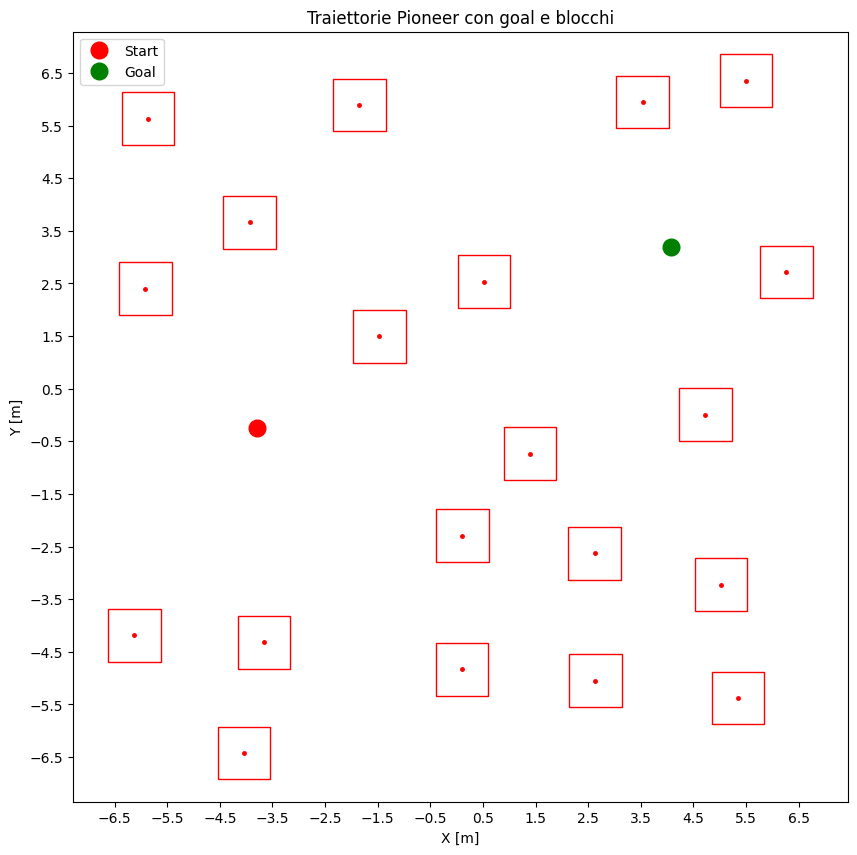

In [9]:
plot_tot(pioneer_position, block_positions, goal_position)

In [10]:
import math

def place_pioneer(robot_handle, block_positions, goal_position, floor_handle, sim,
                  step=0.5, forbidden_radius=1.0):

    floor_pos = sim.getObjectPosition(floor_handle, -1)

    xmin = floor_pos[0] - 6.5
    xmax = floor_pos[0] + 6.5
    ymin = floor_pos[1] - 6.5
    ymax = floor_pos[1] + 6.5
    z = floor_pos[2] + 0.5

    valid_positions = []

    def is_forbidden(x, y):
        # check distanza dal goal singolo
        if math.dist((x, y), goal_position) <= forbidden_radius / 1.2:
            return True

        # check distanza da ogni blocco
        for b in block_positions:
            if math.dist((x, y), b) <= forbidden_radius / 1.1:
                return True

        return False

    # genera griglia
    x = xmin
    while x <= xmax:
        y = ymin
        while y <= ymax:
            px = round(x, 3)
            py = round(y, 3)

            if not is_forbidden(px, py):
                valid_positions.append((px, py))

            y += step
        x += step

    return valid_positions


In [11]:
def plot_grid(pioneer_positions, block_positions, goal_position, grid_positions=None):
    plt.figure(figsize=(10, 10))
    plt.title("Traiettorie Pioneer con goal, blocchi e griglia posizioni")
    plt.xlabel("X [m]")
    plt.ylabel("Y [m]")
    plt.grid(True)
    plt.axis('equal')

    block_size = 1.0

    plt.xticks(np.arange(8.5, -8.5, -1))
    plt.yticks(np.arange(8.5, -8.5, -1))

    # --- Start ---
    plt.plot(pioneer_positions[0], pioneer_positions[1], 'ro', markersize=12, label='Start')

    # --- Goal ---
    plt.plot(goal_position[0], goal_position[1], 'go', markersize=12, label='Goal')

    # --- Blocchi ---
    for (x, y) in block_positions:
        rect = plt.Rectangle((x - block_size/2, y - block_size/2),
                             block_size, block_size,
                             linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        plt.plot(x, y, 'r.', markersize=5)

    # --- Nuove posizioni (griglia) ---
    if grid_positions is not None:
        xs = [p[0] for p in grid_positions]
        ys = [p[1] for p in grid_positions]
        plt.plot(xs, ys, 'c.', markersize=4, alpha=0.5, label='Grid positions')

    plt.grid(False)
    plt.legend()
    plt.show()


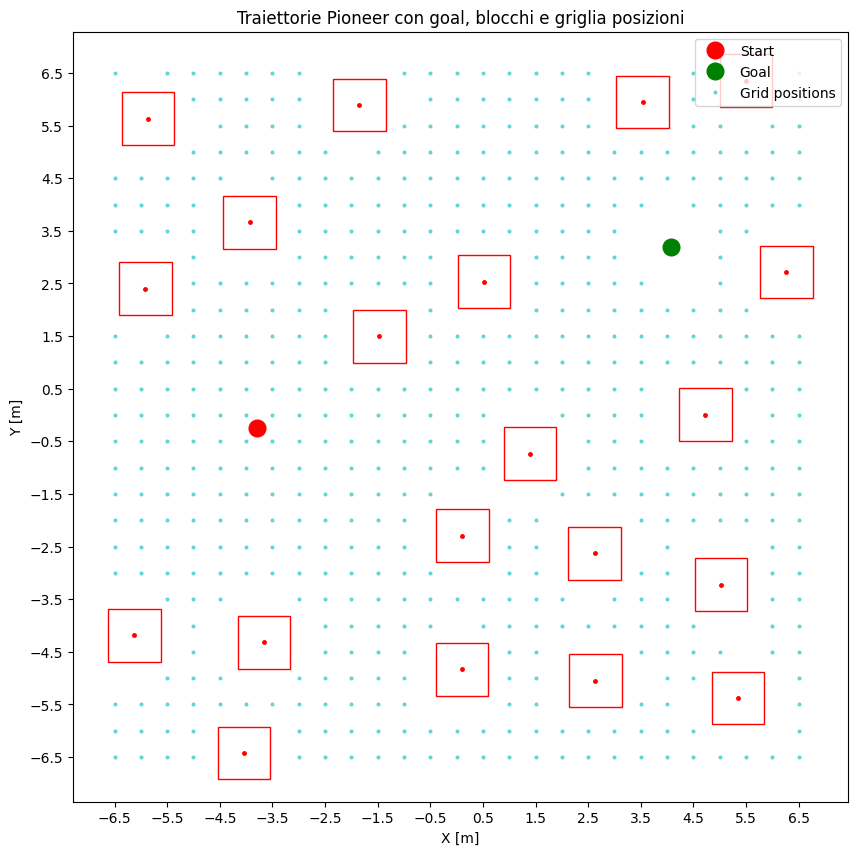

In [12]:
grid_positions = place_pioneer(pioneer, block_positions, goal_position, floor_handle, sim)
plot_grid(pioneer_position, block_positions, goal_position, grid_positions) 

In [13]:
def get_img(sim, camera):
    image, resolution = sim.getVisionSensorImg(camera)
    img = np.array(sim.unpackUInt8Table(image), dtype=np.uint8).reshape(resolution[1], resolution[0], 3)
    img = np.flipud(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = cv2.resize(img, (28, 28))
    return img

def init_sensors(sim):
    sensors = []
    for i_s in range(16):
        sensors.append(sim.getObject(f'/PioneerP3DX/ultrasonicSensor[{i_s}]'))
    return sensors


def read_proximity_sensors(sim, sensors):
    sensors_vals = []
    for sensor in sensors:
        detected, distance, *_ = sim.readProximitySensor(sensor)
        sensors_vals.append(distance if detected else 0.0)
    return sensors_vals

def compute_reconstruction_error(model,sample):
    model.eval()
    spk,mem = model(sample)
    mem = torch.mean(mem,axis=0)
    # print(np.mean(mem.detach().cpu().numpy()))
    # print(np.var(mem.detach().cpu().numpy()))
    # print(np.std(mem.detach().cpu().numpy()))
    mse = torch.nn.MSELoss()
    return mse(sample,mem).item()

import math

def set_robot_orientation(direction):
    if direction == "north":
        gamma = math.pi / 2
    elif direction == "south":
        gamma = -math.pi / 2
    elif direction == "east":
        gamma = 0
    elif direction == "west":
        gamma = math.pi
    else:
        raise ValueError("Direzione non valida: usa north/south/east/west")

    return gamma




In [14]:
gamma = []
directions = ["north", "south", "east", "west"]
for dir in directions:
    gamma.append(set_robot_orientation(dir))

In [17]:
init_sensors(sim)

[46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]

In [18]:
grid_positions

[(-6.5, -6.5),
 (-6.5, -6.0),
 (-6.5, -5.5),
 (-6.5, -3.0),
 (-6.5, -2.5),
 (-6.5, -2.0),
 (-6.5, -1.5),
 (-6.5, -1.0),
 (-6.5, -0.5),
 (-6.5, 0.0),
 (-6.5, 0.5),
 (-6.5, 1.0),
 (-6.5, 1.5),
 (-6.5, 3.5),
 (-6.5, 4.0),
 (-6.5, 4.5),
 (-6.5, 6.5),
 (-6.0, -6.5),
 (-6.0, -6.0),
 (-6.0, -5.5),
 (-6.0, -3.0),
 (-6.0, -2.5),
 (-6.0, -2.0),
 (-6.0, -1.5),
 (-6.0, -1.0),
 (-6.0, -0.5),
 (-6.0, 0.0),
 (-6.0, 0.5),
 (-6.0, 1.0),
 (-6.0, 3.5),
 (-6.0, 4.0),
 (-6.0, 4.5),
 (-5.5, -6.5),
 (-5.5, -6.0),
 (-5.5, -5.5),
 (-5.5, -5.0),
 (-5.5, -3.5),
 (-5.5, -3.0),
 (-5.5, -2.5),
 (-5.5, -2.0),
 (-5.5, -1.5),
 (-5.5, -1.0),
 (-5.5, -0.5),
 (-5.5, 0.0),
 (-5.5, 0.5),
 (-5.5, 1.0),
 (-5.5, 1.5),
 (-5.5, 3.5),
 (-5.5, 4.0),
 (-5.5, 4.5),
 (-5.5, 6.5),
 (-5.0, -6.5),
 (-5.0, -6.0),
 (-5.0, -5.5),
 (-5.0, -5.0),
 (-5.0, -4.5),
 (-5.0, -4.0),
 (-5.0, -3.5),
 (-5.0, -3.0),
 (-5.0, -2.5),
 (-5.0, -2.0),
 (-5.0, -1.5),
 (-5.0, -1.0),
 (-5.0, -0.5),
 (-5.0, 0.0),
 (-5.0, 0.5),
 (-5.0, 1.0),
 (-5.0, 1.5),
 (-5.0

In [16]:
heatmaps = {
    "north": [],
    "south": [],
    "east": [],
    "west": []
}
client = RemoteAPIClient()
sim = client.getObject('sim')
sim.loadScene('C:/Users/anton/Documents/PhD/Spiking/PotentialField_Sim/potential_fields_sim.ttt')

for i,g in enumerate(gamma):
    sim.startSimulation()

    pioneer = sim.getObject('/PioneerP3DX')
    camera = sim.getObject('/PioneerP3DX/Vision_sensor')

    left_motor = sim.getObject("/PioneerP3DX/leftMotor")
    right_motor = sim.getObject("/PioneerP3DX/rightMotor")

    template_handle = sim.getObject("/ConcretBlockTemplate")
    floor_handle = sim.getObject("/ResizableFloor_5_25")

    goal_handle = sim.getObject("/goal")
    sensors = init_sensors(sim)
    sim.setStepping(True)

    model = SAE(num_inputs=800, num_hidden=500, num_outputs=800, num_steps=25, beta=0.95) 
    checkpoint = torch.load("SpikingAE_new.pth")
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    pioneer_position, goal_position, block_positions = place_objects(
        sim,
        seed=22,
        num_blocks=20,
        min_distance=2.0,
        min_goal_distance=8.0,
        template_handle=template_handle,
        floor_handle=floor_handle,
        robot_handle=pioneer,
        goal_handle=goal_handle
    )

    grid_positions = place_pioneer(pioneer, block_positions, goal_position, floor_handle, sim)

    heatmap = []
    THR = 0.1896
    for x,y in grid_positions:
        sim.setObjectPosition(pioneer, -1, [x, y, 0.13])
        sim.setObjectOrientation(pioneer, -1, [0, 0, g])

        img = get_img(sim, camera)  
        img_gray = img[:,:,0]
        img_gray = img_gray.flatten()
        sensors_vals = read_proximity_sensors(sim, sensors)
        X_img_tensor = torch.tensor(img_gray, dtype=torch.float32)
        X_img_tensor = X_img_tensor.unsqueeze(0)
        X_scaled = X_img_tensor / 255.0
        # X_scaled = X_img_tensor / 127.5 - 1


        sensors_vals = read_proximity_sensors(sim, sensors)
        X_sensor_tensor = torch.tensor(sensors_vals, dtype=torch.float32).unsqueeze(0)

        X_total = torch.concat((X_scaled, X_sensor_tensor), axis=-1)
        value = compute_reconstruction_error(model, X_total) 

        heatmap.append((x, y, value))
        sim.step()

    sim.stopSimulation()
    heatmaps[directions[i]] = heatmap
    time.sleep(5)

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# import joblib
# # scaler = joblib.load("minmax_scaler.pkl")



In [17]:
heatmaps["north"][4]

(-6.5, -2.5, 0.0071243178099393845)

In [21]:
THR = 0.00561774
# THR = 0.1896
# sinistra-destra-su-giu

direzione = ["←", "→", "↑", "↓"]

In [48]:
def plot_hmap(pioneer_positions, block_positions, goal_position, grid_positions=None, heatmap_values=None, direction=None, ax=None):
    # ax.figure(figsize=(5, 5))
    ax.set_xlabel("X [m]")
    ax.set_ylabel("Y [m]")
    # ax.grid(True)
    ax.axis('equal')

    block_size = 1.0

    ax.set_xticks(np.arange(8.5, -8.5, -1))
    ax.set_yticks(np.arange(8.5, -8.5, -1))

    # --- Start ---
    # ax.plot(pioneer_positions[0], pioneer_positions[1], 'ro', markersize=12, label='Start')

    # --- Goal ---
    ax.plot(goal_position[0], goal_position[1], 'bo', markersize=12, label='Goal')

    # --- Blocchi ---
    from matplotlib.patches import Rectangle

    for (x, y) in block_positions:
        rect = Rectangle(
            (x - block_size/2, y - block_size/2),
            block_size,
            block_size,
            linewidth=1,
            edgecolor='r',
            facecolor='none'
        )

        ax.add_patch(rect)       # ✔ aggiungi la patch all'axes desiderato
        ax.plot(x, y, 'r.', markersize=5)   # ✔ plot sullo stesso axes


    # --- Griglia posizioni ---
    # if grid_positions is not None:
    #     xs = [p[0] for p in grid_positions]
    #     ys = [p[1] for p in grid_positions]
    #     ax.plot(xs, ys, 'c.', markersize=4, alpha=0.3, label='Grid positions')

    # --- Heatmap basata sul valore ---
    if heatmap_values is not None:
        for (x, y, val) in heatmap_values:
            color = 'red' if val > THR else 'green'
            ax.plot(x, y, 'o', color=color, markersize=6, alpha=0.6)

    ax.grid(False)
    ax.legend()
    # ax.show()


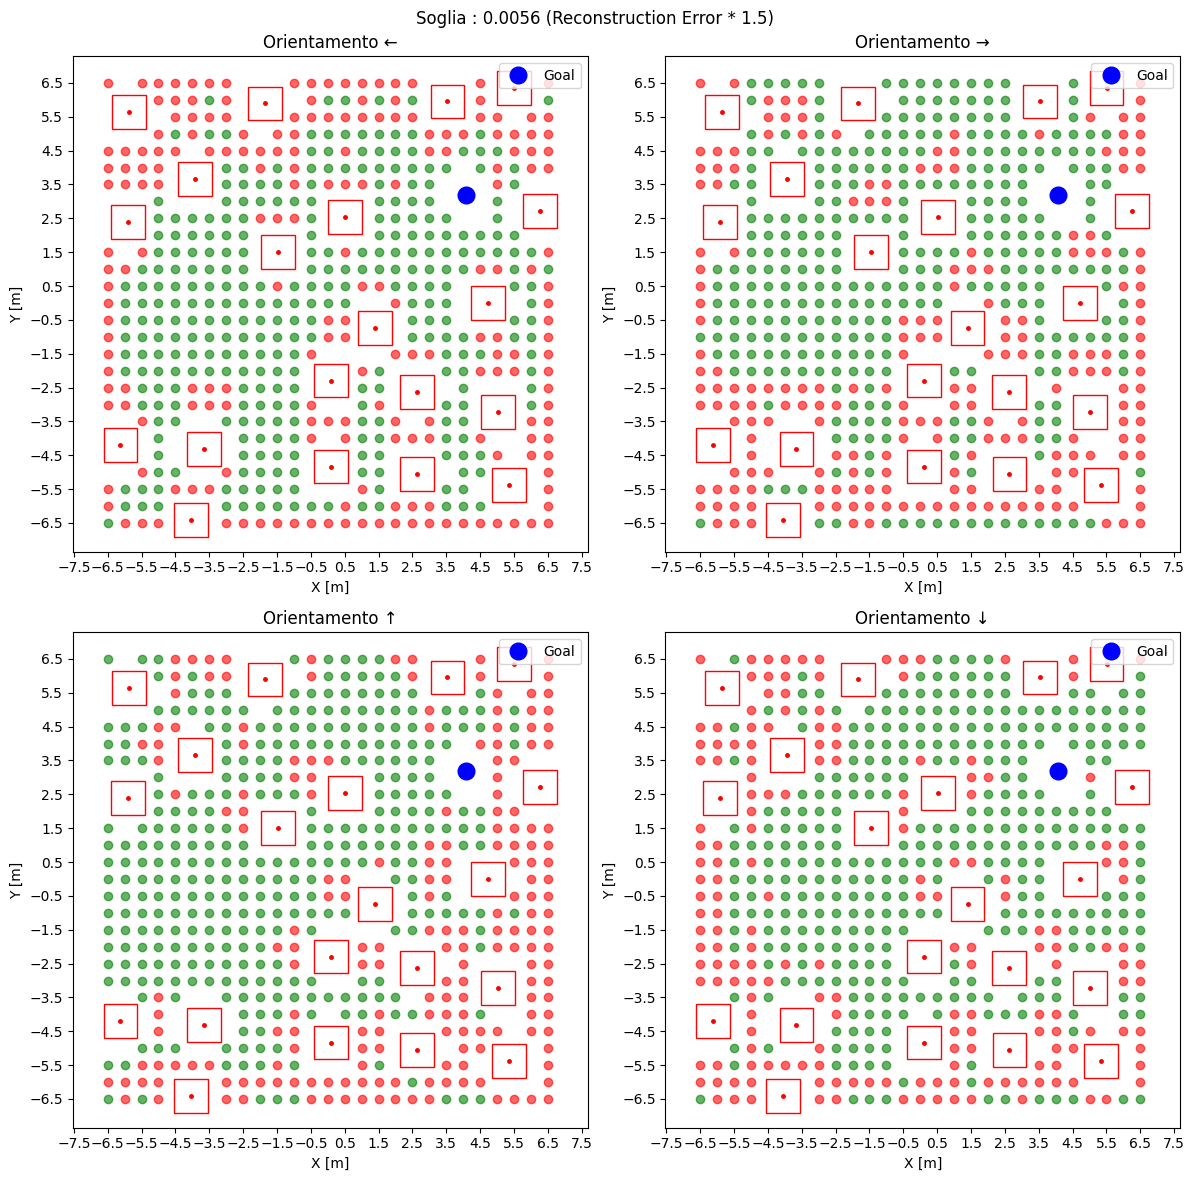

In [51]:
import matplotlib.pyplot as plt
THR = 0.00561774 
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
plt.suptitle(f"Soglia : {THR:.4f} (Reconstruction Error * 1.5)")
for i, dir in enumerate(directions):
    ax = axes[i // 2, i % 2]   # seleziona la subplot corretta
    plot_hmap(
        pioneer_position,
        block_positions,
        goal_position,
        grid_positions,
        heatmaps[dir],
        ax=ax                 # passa l'axes su cui disegnare
    )
    ax.set_title(f"Orientamento {direzione[i]}")

plt.tight_layout()
plt.show()


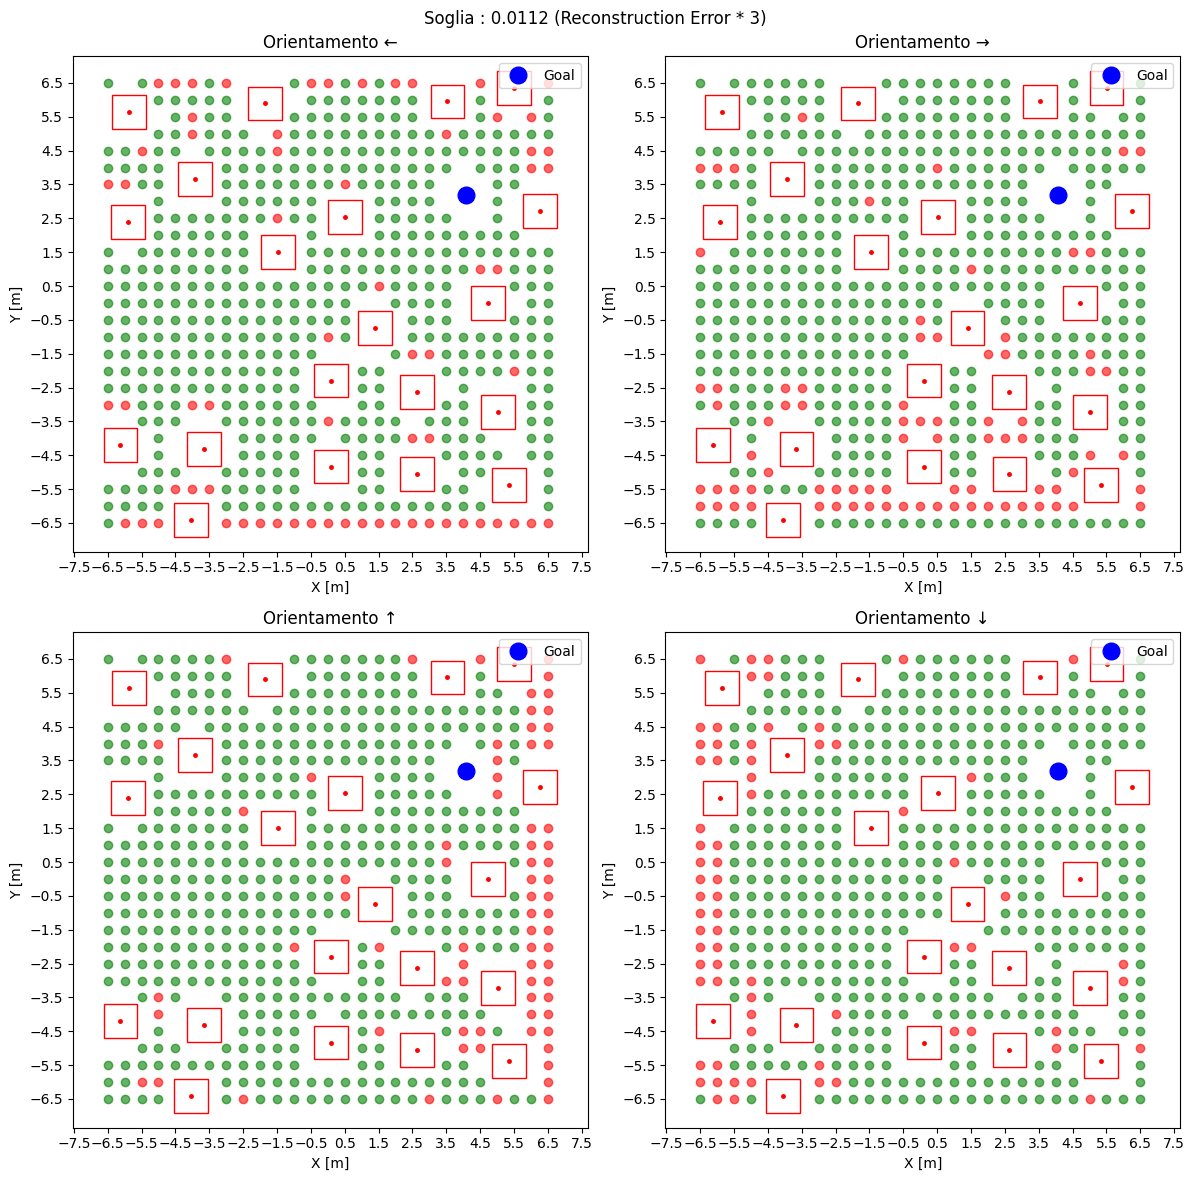

In [45]:
import matplotlib.pyplot as plt
THR = 0.00561774 * 2
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
plt.suptitle(f"Soglia : {THR:.4f} (Reconstruction Error * 3)")
for i, dir in enumerate(directions):
    ax = axes[i // 2, i % 2]   # seleziona la subplot corretta
    plot_hmap(
        pioneer_position,
        block_positions,
        goal_position,
        grid_positions,
        heatmaps[dir],
        ax=ax                 # passa l'axes su cui disegnare
    )
    ax.set_title(f"Orientamento {direzione[i]}")

plt.tight_layout()
plt.show()


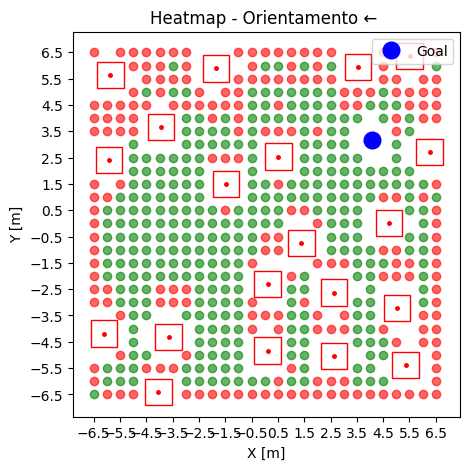

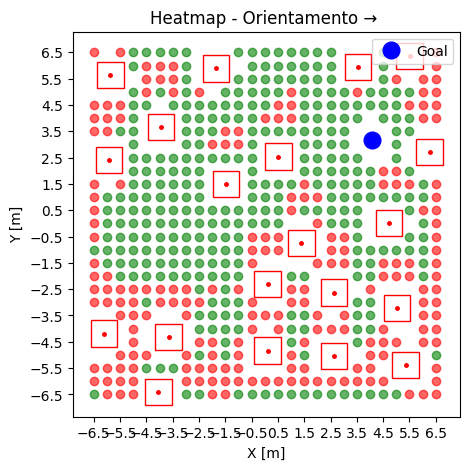

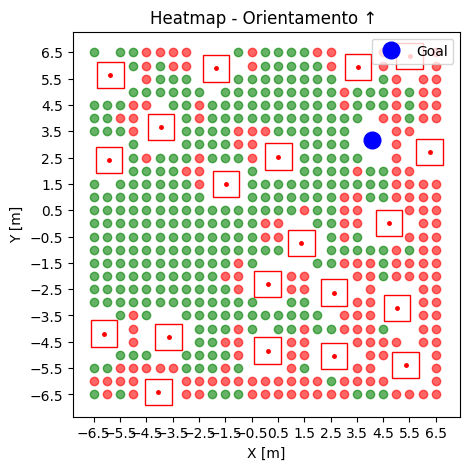

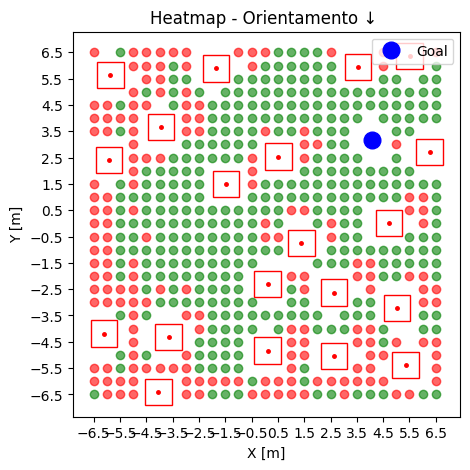

In [23]:
for i, dir in enumerate(directions):
    plot_hmap(pioneer_position, block_positions, goal_position, grid_positions, heatmaps[dir], i)

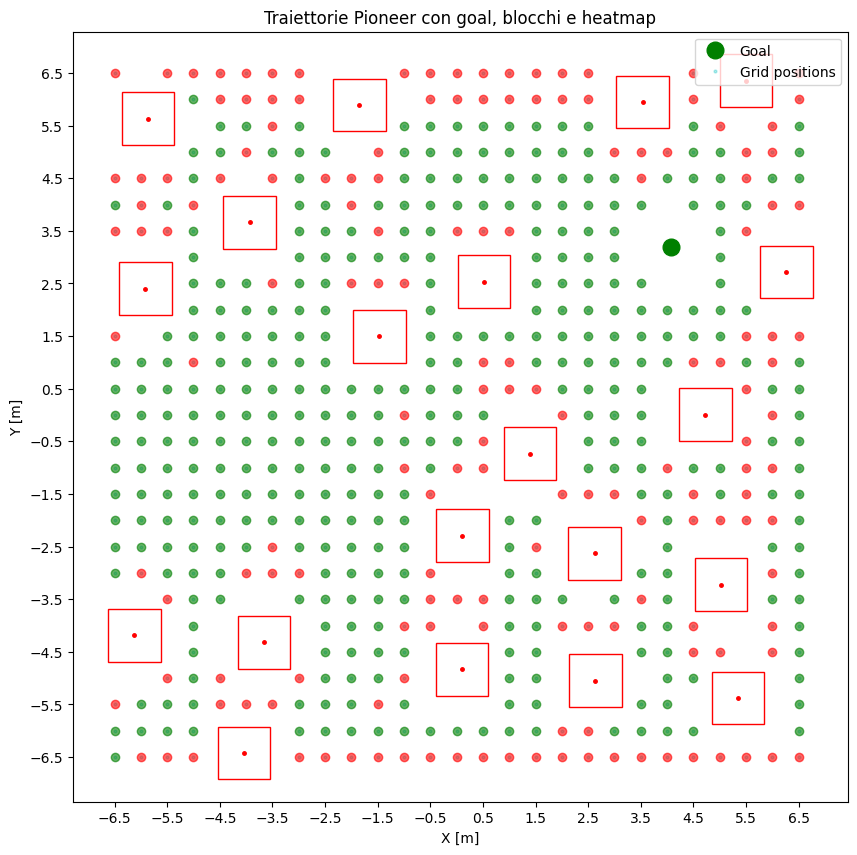

In [34]:
plot_hmap(pioneer_position, block_positions, goal_position, grid_positions, heatmaps["north"])

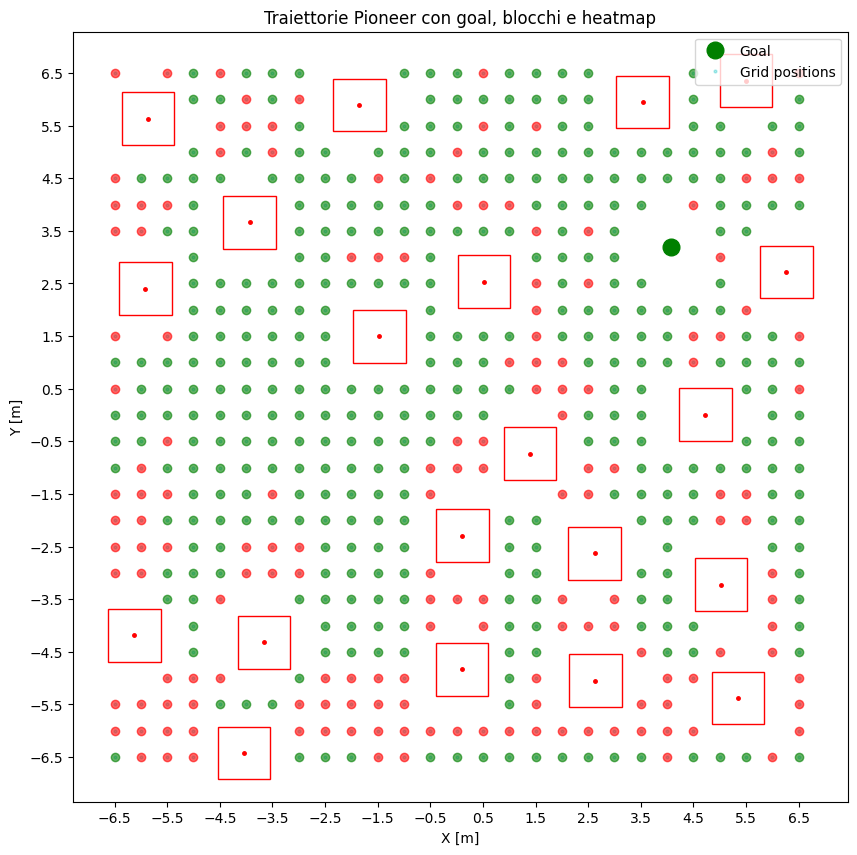

In [35]:
plot_hmap(pioneer_position, block_positions, goal_position, grid_positions, heatmaps["south"])

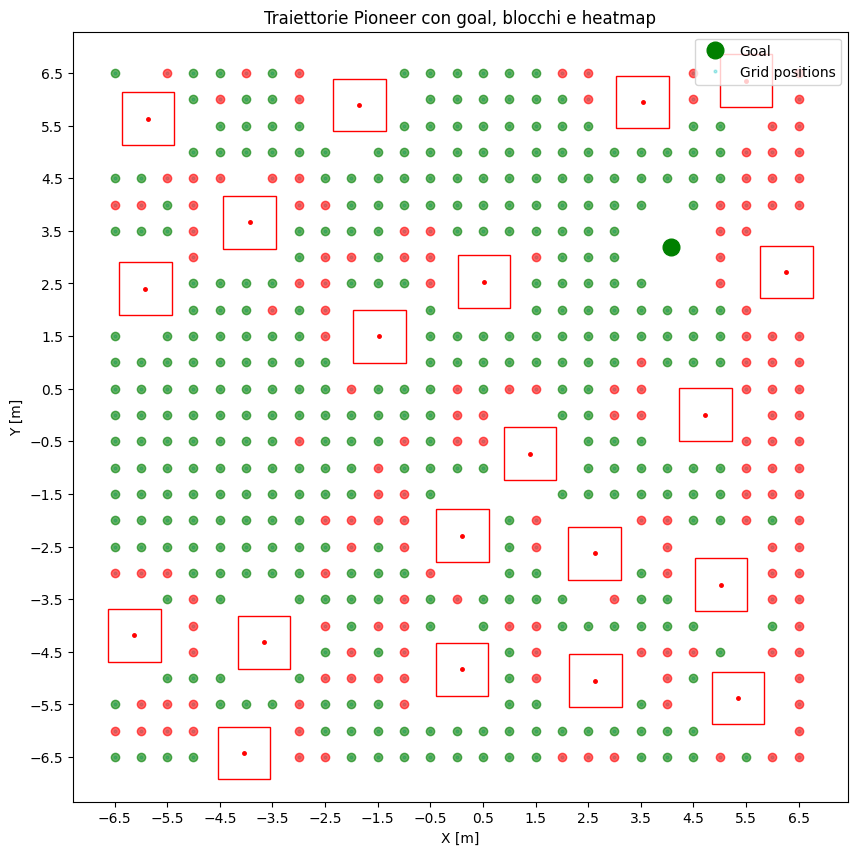

In [36]:
plot_hmap(pioneer_position, block_positions, goal_position, grid_positions, heatmaps["east"])

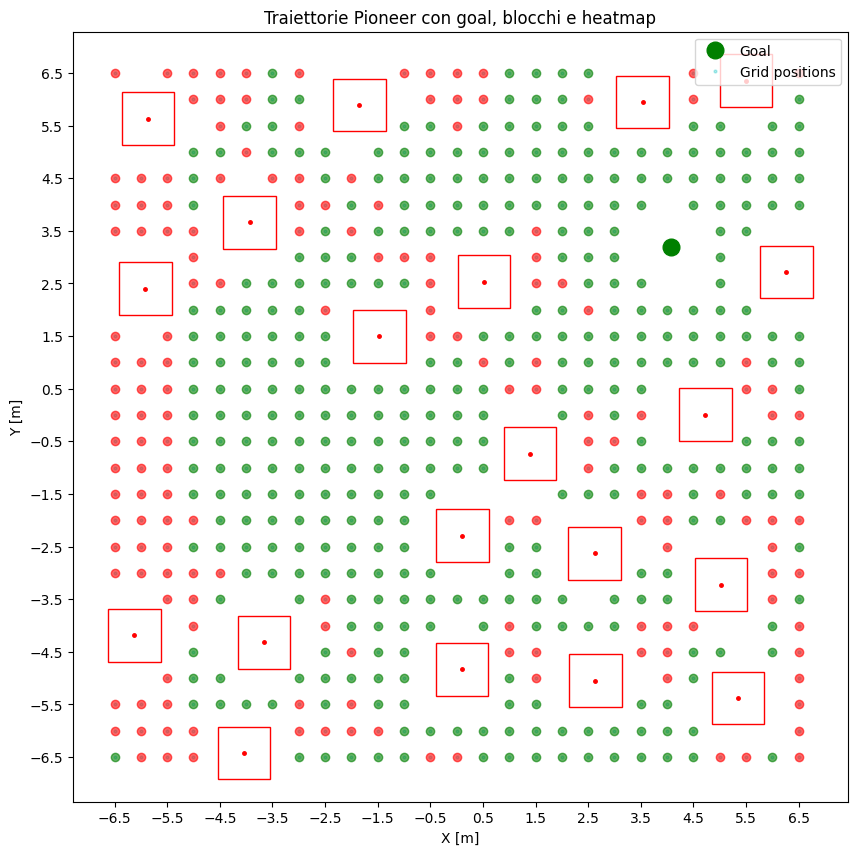

In [37]:
plot_hmap(pioneer_position, block_positions, goal_position, grid_positions, heatmaps["west"])

In [ ]:
def save_frame(frame_dir, camera, frame_id, sim):
    image, resolution = sim.getVisionSensorImg(camera)
    img = np.array(sim.unpackUInt8Table(image), dtype=np.uint8).reshape(resolution[1], resolution[0], 3)
    img = np.flipud(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    filename = os.path.join(frame_dir, f"frame_{frame_id:04d}.png")
    cv2.imwrite(filename, img)



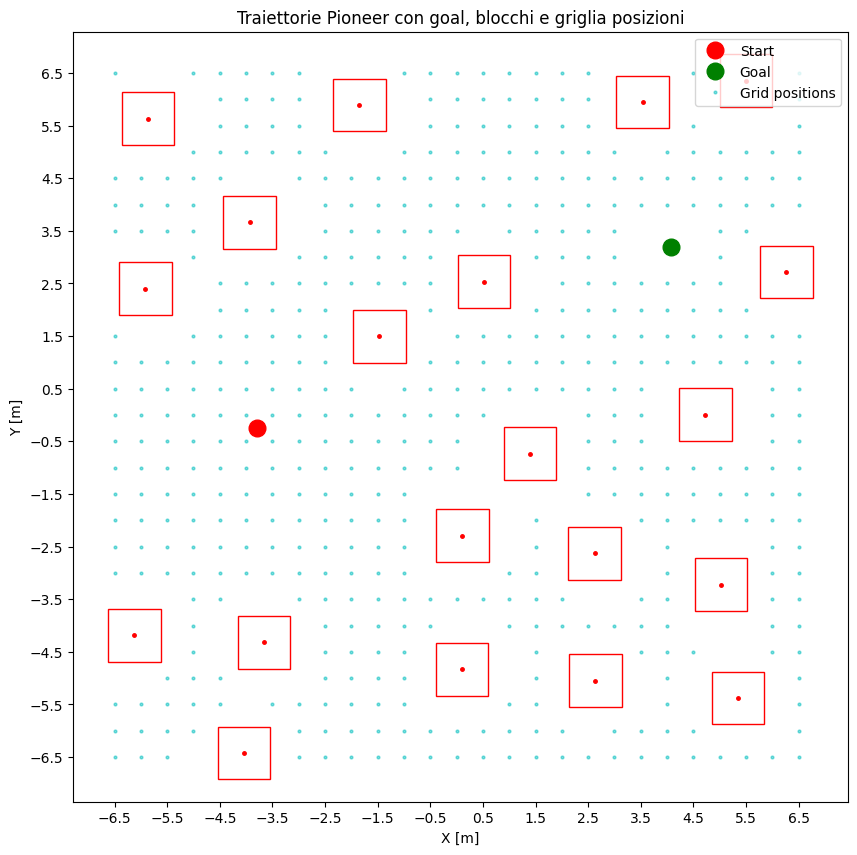

In [ ]:
plot_grid(pioneer_position, block_positions, goal_position, grid_positions)